### Import packages-libraries

In [1]:
import pandas as pd
import numpy as np

import urllib3
import requests
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from nltk.stem.porter import *
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

%matplotlib inline

### Read from file

In [2]:
train_data = pd.read_csv('datasets/q1/train.csv', sep=',')
test_data = pd.read_csv('datasets/q1/test_without_labels.csv', sep=',')
#test_data['Label'] = train_data['Label']
expected_array = np.array(train_data.head(2000)[['Label']]).flatten()
content_array = np.array(train_data.head(2000)[['Content']]).flatten()
#X_train = train_data['Content'].head(2000)
#Y_train = train_data['Label'].head(2000)
#X_test = test_data['Content']
#Y_test = test_data['Label']

my_additional_stop_words = ['said','still','day','will','new','may','two','one','now','time','say','second','month','first','going','year','back','people','case','according']
stop_words = STOPWORDS.union(my_additional_stop_words)

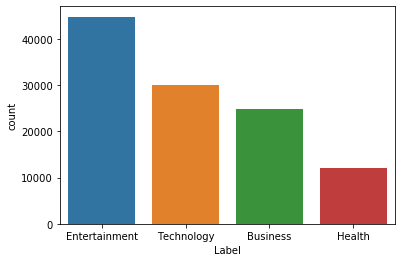

In [3]:
sns.countplot(x='Label',data=train_data)

In [4]:
traindata = train_data.groupby('Label').count()
print(traindata)

                  Id  Title  Content
Label                               
Business       24834  24834    24834
Entertainment  44834  44834    44834
Health         12020  12020    12020
Technology     30107  30107    30107


### Cleaning Data

In [3]:
df_entertainment = train_data[train_data['Label']=='Entertainment'].head(1300)
df_health = train_data[train_data['Label']=='Health'].head(400)
df_business = train_data[train_data['Label']=='Business'].head(700)
df_technology = train_data[train_data['Label']=='Technology'].head(950)
df = pd.concat([df_entertainment,df_health,df_business,df_technology])

#X_train = df['Content']
#Y_train = df['Label']
#X_test = df['Content']
#Y_test = test_data['Label']

X = df['Title']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

set(df['Label'])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
y = le.transform(df['Label'])
set(y)

{0, 1, 2, 3}

### Wordcloud 

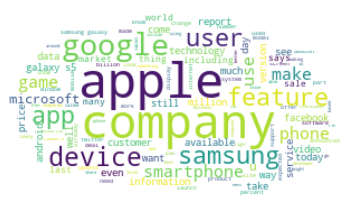

In [10]:
#STOPWORDS.extend(['will', 'said', 'us', 'may', 'share','well'])

business = str()
entertainment = str()
health = str()
technology = str()
for i in range(expected_array.shape[0]):
    if expected_array[i] == 'Business':
        business = business + ' ' + str(content_array[i])
    elif expected_array[i] == 'Entertainment':
        entertainment = entertainment + ' ' + str(content_array[i])
    elif expected_array[i] == 'Health':
        health = health + ' ' + str(content_array[i])
    elif expected_array[i] == 'Technology':
        technology = technology + ' ' + str(content_array[i])
        
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/3/0/a/1/11971238241310805346noonespillow_Simple_Cloud.svg.med.png',stream=True).raw))

wordcloud1 = WordCloud(stopwords=stop_words, background_color="white", mask=mask).generate(business)
plt.imshow(wordcloud1,interpolation='bilinear')
plt.axis("off")
plt.savefig('q1/business.png')

wordcloud2 = WordCloud(stopwords=stop_words,background_color="white",mask=mask).generate(entertainment)
plt.imshow(wordcloud2,interpolation='bilinear')
plt.axis("off")
plt.savefig('q1/entertainment.png')

wordcloud3 = WordCloud(stopwords=stop_words,background_color="white",mask=mask).generate(health)
plt.imshow(wordcloud3,interpolation='bilinear')
plt.axis("off")
plt.savefig('q1/health.png')

wordcloud4 = WordCloud(stopwords=stop_words,background_color="white",mask=mask).generate(technology)
plt.imshow(wordcloud4,interpolation='bilinear')
plt.axis("off")
plt.savefig('q1/technology.png')

### Building Vectors

In [4]:
#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_train)

print("building tfidf")

#vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.9, min_df=3)
vectorizer = TfidfVectorizer(stop_words = 'english', use_idf=True)
X_train_tfidf = vectorizer.fit_transform(X_train) 
X_test_vect = vectorizer.transform(X_test) 

print("Building SVD")
#truncated svd
lsa=TruncatedSVD(n_components = 20)
svd_transformer = make_pipeline(vectorizer,lsa)
X_train_svd = svd_transformer.fit_transform(df['Title'])

building tfidf
Building SVD


### SVM (Bag of Words)

In [5]:
#set candidate parameters
parameters = {'kernel':['rbf'], 'C': [4,8,16], 'gamma': [0.1,0.01]}

print("before determing model")

#determine the model
svc = SVC()
clf = GridSearchCV(svc,parameters,cv=5)

print("before feeding data")
# Feed the training data
clf.fit(X_train_tfidf, y_train)  

print("before predicting")
predictions = clf.predict(X_test_vect)
#preds = le.inverse_transform(predictions )

print(metrics.confusion_matrix(y_test,predictions))

print(metrics.classification_report(y_test,predictions))

dfr = classification_report(y_test,predictions,output_dict = True)
macro_precision = dfr['macro avg']['precision']
macro_recall = dfr['macro avg']['recall']
macro_f1 = dfr['macro avg']['f1-score']

before determing model
before feeding data
before predicting
[[152  26   2  31]
 [ 15 425   3  10]
 [ 12  22  85   8]
 [ 34  20   1 260]]
               precision    recall  f1-score   support

     Business       0.71      0.72      0.72       211
Entertainment       0.86      0.94      0.90       453
       Health       0.93      0.67      0.78       127
   Technology       0.84      0.83      0.83       315

     accuracy                           0.83      1106
    macro avg       0.84      0.79      0.81      1106
 weighted avg       0.84      0.83      0.83      1106



### SVM (svd)

In [10]:
parameters2 = {'kernel':['rbf'], 'C': [4,8,16], 'gamma': [0.1,0.01]}
s2 = SVC()
s = GridSearchCV(s2,parameters2, cv=5)

#scores=cross_val_score(s,X_train_svd,y,cv=5,scoring='accuracy')
#score= scores.mean()
#print (score)
predicted = cross_val_predict(s, X_train_svd, y, cv=5) #5-fold cross validation
print (accuracy_score(y, predicted)) 

print(metrics.confusion_matrix(y,predicted))

print(metrics.classification_report(y,predicted))

dfr2 = classification_report(y,predicted,output_dict = True)
macro_precision2 = dfr2['macro avg']['precision']
macro_recall2 = dfr2['macro avg']['recall']
macro_f12 = dfr2['macro avg']['f1-score']

0.5940298507462687
[[ 198  440    8   54]
 [  35 1243    3   19]
 [  39  286   68    7]
 [  88  372    9  481]]
              precision    recall  f1-score   support

           0       0.55      0.28      0.37       700
           1       0.53      0.96      0.68      1300
           2       0.77      0.17      0.28       400
           3       0.86      0.51      0.64       950

    accuracy                           0.59      3350
   macro avg       0.68      0.48      0.49      3350
weighted avg       0.66      0.59      0.56      3350



### Random Forests (Bag of words)

In [36]:
rfc1 = RandomForestClassifier(n_estimators=100)
params = {'n_estimators':[100]}
rfc = GridSearchCV(rfc1,params, cv=5)
rfc.fit(X_train_tfidf, y_train)
rfc_pred = rfc.predict(X_test_vect)

#print(metrics.confusion_matrix(y_test,predictions))

print(metrics.classification_report(y_test,rfc_pred))

dfr3 = classification_report(y_test,rfc_pred,output_dict = True)
macro_precision3 = dfr3['macro avg']['precision']
macro_recall3 = dfr3['macro avg']['recall']
macro_f13 = dfr3['macro avg']['f1-score']

               precision    recall  f1-score   support

     Business       0.78      0.49      0.60       211
Entertainment       0.68      0.95      0.79       453
       Health       0.82      0.53      0.64       127
   Technology       0.87      0.70      0.78       315

     accuracy                           0.74      1106
    macro avg       0.79      0.67      0.70      1106
 weighted avg       0.77      0.74      0.73      1106



### Random Forests (svd)

In [8]:
m = RandomForestClassifier(n_estimators = 100)
#scores=cross_val_score(m,X,y,cv=5,scoring='accuracy')

r_predicted = cross_val_predict(m, X_train_svd, y, cv=5) #5-fold cross validation
print (accuracy_score(y, r_predicted))
print(metrics.classification_report(y,r_predicted))

dfr4 = classification_report(y,r_predicted,output_dict = True)
macro_precision4 = dfr4['macro avg']['precision']
macro_recall4 = dfr4['macro avg']['recall']
macro_f14 = dfr4['macro avg']['f1-score']

0.72
              precision    recall  f1-score   support

           0       0.62      0.61      0.61       700
           1       0.74      0.87      0.80      1300
           2       0.74      0.48      0.59       400
           3       0.76      0.69      0.72       950

    accuracy                           0.72      3350
   macro avg       0.71      0.66      0.68      3350
weighted avg       0.72      0.72      0.71      3350



### My Method

In [5]:
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')

def processText(text):
    p_stemmer = SnowballStemmer(language='english')
    tokens = word_tokenize(text)
    #stems = []
    #doc = nlp(text)
    #for token in doc:
    #    stems.append(p_stemmer.stem(token))
    stems = [p_stemmer.stem(t) for t in tokens]
    return stems

X = df['Content']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


vectorizer = TfidfVectorizer(tokenizer=processText, stop_words = stop_words, use_idf=True)
X_train_tfidf = vectorizer.fit_transform(X_train) 
X_test_vect = vectorizer.transform(X_test) 

params2 = {'alpha':[1], 'norm':[True]}


#knn = KNeighborsClassifier(n_neighbors=13, weights='distance', algorithm='auto', leaf_size=30, metric='minkowski')
#knn.fit(X_train_tfidf, y_train)
#ml2 = MultinomialNB(alpha=1, fit_prior=True)
nb2 = ComplementNB(alpha=1, norm=True)
nb = GridSearchCV(nb2,params2,cv=5)

nb.fit(X_train_tfidf, y_train)
pred5 = nb.predict(X_test_vect)

print(classification_report(y_test,pred5))

dfr5 = classification_report(y_test,pred5,output_dict = True)
macro_precision5 = dfr5['macro avg']['precision']
macro_recall5 = dfr5['macro avg']['recall']
macro_f15 = dfr5['macro avg']['f1-score']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'accord', 'ani', 'becaus', 'befor', 'ca', 'doe', 'dure', 'els', 'go', 'henc', 'howev', 'let', 'll', 'must', "n't", 'onc', 'onli', 'otherwis', 'ourselv', 'peopl', 're', 'sha', 'sinc', 'themselv', 'therefor', 've', 'veri', 'whi', 'wo', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


               precision    recall  f1-score   support

     Business       0.87      0.76      0.81       211
Entertainment       0.86      0.98      0.92       453
       Health       1.00      0.66      0.80       127
   Technology       0.86      0.88      0.87       315

     accuracy                           0.87      1106
    macro avg       0.90      0.82      0.85      1106
 weighted avg       0.88      0.87      0.87      1106



### Predicting Test file

In [6]:
df_test = test_data['Content']
X_test_vector = vectorizer.transform(df_test)

In [7]:
pred_final = nb.predict(X_test_vector)

In [8]:
to_print_arr = np.array(test_data[['Id']]).flatten()
columns = pd.Index(['Id','Predicted'])
data = np.column_stack((to_print_arr,pred_final))
df_final = pd.DataFrame(data, index=None, columns = columns)
df_final.to_csv('q1/testSet_categories.csv', sep=',', index=False)

### Requirement 1 complete